# **⚖️ Part 4: Class Imbalance Handling & Model Building**

# Table of Contents

1. [Handle Class Imbalance](#handle-class-imbalance)
2. [Train-Test Split](#train-test-split)
3. [Build Multiple Models](#build-multiple-models)
4. [Model Comparison](#model-comparison)
5. [Hyperparameter Tuning](#hyperparameter-tuning)

# **1. Handle Class Imbalance**

# **📚 Setup**

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load processed data
df = pd.read_csv('data_ready_for_modeling.csv')



In [67]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic.1,InternetService_No.1,PaymentMethod_Credit card (automatic).1,PaymentMethod_Electronic check.1,PaymentMethod_Mailed check.1,City_freq,PaymentMethod_target
0,1092-KIO,Male,0,No,No,1.655518,Yes,Yes,No,No internet service,...,-0.538563,-0.707897,-0.543852,-0.912124,1.911594,-0.538563,-0.707897,-0.543852,-1.362393,-0.711025
1,5379-KIO,Male,0,Yes,No,1.655518,Yes,Yes,No,No internet service,...,1.856794,-0.707897,-0.543852,-0.912124,1.911594,1.856794,-0.707897,-0.543852,0.813909,-0.609964
2,6633-CFO,Female,0,No,No,1.655518,Yes,Yes,No,No internet service,...,-0.538563,-0.707897,1.838737,-0.912124,1.911594,-0.538563,-0.707897,1.838737,-0.307217,-0.797322
3,8004-VHV,Female,0,No,No,1.655518,Yes,No,No,No internet service,...,1.856794,-0.707897,-0.543852,-0.912124,1.911594,1.856794,-0.707897,-0.543852,-0.505062,-0.609964
4,1418-GNV,Male,0,No,No,1.655518,Yes,No,DSL,No,...,1.856794,-0.707897,-0.543852,-0.912124,-0.523124,1.856794,-0.707897,-0.543852,-0.373165,-0.609964


In [68]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'SignupDate', 'LastContactDate', 'NumServiceTickets', 'NumTechTickets',
       'NumAdminTickets', 'CustomerSatisfactionScore', 'DownloadSpeed',
       'UploadSpeed', 'ContractRenewals', 'City', 'Region', 'AccountAgeYears',
       'TotalServicesUsed', 'AvgChargePerService', 'PaymentDelay',
       'AvgChargePerMonth', 'TotalServices', 'ChargePerService',
       'SeniorWithPartner', 'HasFiberInternet', 'TotalAddonServices',
       'HasAnyAddon', 'ServiceAdoptionRate', 'TenureGroup', 'ChargeGroup',
       'ValueSegment', 'SignupYear', 'SignupMonth', 'SignupQuarter',
       'SignupDayOfWeek', 'DaysSinceSignup', 'tenure_squared',
   

In [69]:
df['Churn']

,Churn
0,Yes
1,No
2,No
3,Yes
4,No
...,...
6711,Yes
6712,Yes
6713,Yes
6714,No


# **🔍 Step 1: Check Class Distribution**

💡 **Why Class Imbalance Matters:**

- **Biased models** — Model predicts majority class too often  
- **Poor minority class performance** — Fails to catch churners  
- **Misleading accuracy** — 80% accuracy means nothing if it just predicts "No Churn" always


In [70]:
print("\n" + "="*80)
print("STEP 1: ANALYZE CLASS DISTRIBUTION")
print("="*80)

# Convert Churn to binary (if it's still categorical)
if df['Churn'].dtype == 'object' or df['Churn'].dtype == 'category':
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Check distribution
churn_counts = df['Churn'].value_counts()
churn_percentage = (churn_counts / len(df) * 100).round(2)

print("Churn Distribution:")
print(f"  Class 0 (No Churn):  {churn_counts[0]:,} ({churn_percentage[0]}%)")
print(f"  Class 1 (Churn):     {churn_counts[1]:,} ({churn_percentage[1]}%)")

# Calculate imbalance ratio
imbalance_ratio = churn_counts[0] / churn_counts[1]
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

# Determine severity
if imbalance_ratio < 1.5:
    severity = "Balanced"
elif imbalance_ratio < 3:
    severity = "Slightly Imbalanced"
elif imbalance_ratio < 5:
    severity = "Moderately Imbalanced"
else:
    severity = "Severely Imbalanced"

print(f"Severity: {severity}")




STEP 1: ANALYZE CLASS DISTRIBUTION
Churn Distribution:
  Class 0 (No Churn):  3,649 (54.33%)
  Class 1 (Churn):     3,067 (45.67%)

Imbalance Ratio: 1.19:1
Severity: Balanced


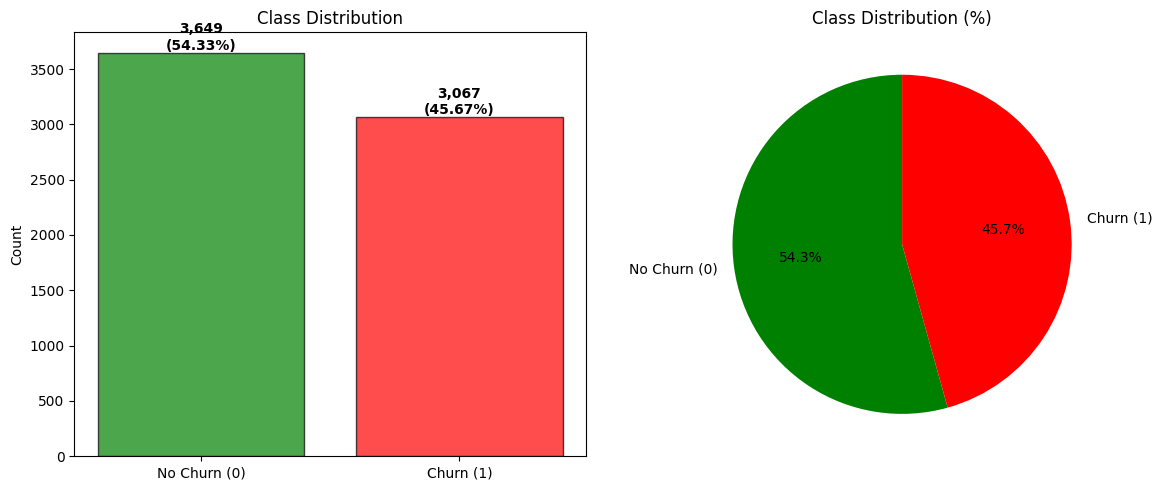


✅ Visualization saved


In [71]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
axes[0].bar(['No Churn (0)', 'Churn (1)'], churn_counts.values,
            color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v, f'{v:,}\n({churn_percentage.values[i]}%)',
                ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(churn_counts.values, labels=['No Churn (0)', 'Churn (1)'],
            autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
axes[1].set_title('Class Distribution (%)')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ Visualization saved")

# **🛠️ Step 2: Method 1 - Random Oversampling**

💡 **Random Oversampling:**

- **Pros:** Simple, fast, balances classes  
- **Cons:** Creates exact duplicates, risk of overfitting  
- **When to use:** Quick baseline, small datasets


In [72]:
# Select only numerical columns
df = df.select_dtypes(include=['int64', 'float64'])

print(f"Numerical columns: {df.shape[1]}")
print(f"Column names:\n{df.columns.tolist()}")

Numerical columns: 52
Column names:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'NumServiceTickets', 'NumTechTickets', 'NumAdminTickets', 'CustomerSatisfactionScore', 'DownloadSpeed', 'UploadSpeed', 'ContractRenewals', 'AccountAgeYears', 'TotalServicesUsed', 'AvgChargePerService', 'PaymentDelay', 'AvgChargePerMonth', 'TotalServices', 'ChargePerService', 'SeniorWithPartner', 'HasFiberInternet', 'TotalAddonServices', 'HasAnyAddon', 'ServiceAdoptionRate', 'SignupYear', 'SignupMonth', 'SignupQuarter', 'SignupDayOfWeek', 'DaysSinceSignup', 'tenure_squared', 'MonthlyCharges_squared', 'tenure_x_MonthlyCharges', 'ChargeIncreaseRate', 'ServiceValueRatio', 'gender_encoded', 'Partner_encoded', 'Dependents_encoded', 'PhoneService_encoded', 'PaperlessBilling_encoded', 'Contract_encoded', 'InternetService_Fiber optic', 'InternetService_No', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'InternetService_Fiber optic.

In [77]:
df.shape

(6688, 52)

In [75]:
df = df.dropna()

In [76]:
df.isna().sum()

,0
SeniorCitizen,0
tenure,0
MonthlyCharges,0
TotalCharges,0
Churn,0
NumServiceTickets,0
NumTechTickets,0
NumAdminTickets,0
CustomerSatisfactionScore,0
DownloadSpeed,0


In [79]:
print("\n" + "="*80)
print("STEP 2: RANDOM OVERSAMPLING")
print("="*80)

from imblearn.over_sampling import RandomOverSampler

# Separate features and target
X = df.drop(['Churn', 'customerID'], axis=1, errors='ignore')
y = df['Churn']

print(f"Before oversampling:")
print(f"  X shape: {X.shape}")
print(f"  Class distribution: {Counter(y)}")

# Apply random oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

print(f"\nAfter oversampling:")
print(f"  X shape: {X_ros.shape}")
print(f"  Class distribution: {Counter(y_ros)}")
print("  ✅ Classes balanced!")


STEP 2: RANDOM OVERSAMPLING
Before oversampling:
  X shape: (6688, 51)
  Class distribution: Counter({0: 3634, 1: 3054})

After oversampling:
  X shape: (7268, 51)
  Class distribution: Counter({1: 3634, 0: 3634})
  ✅ Classes balanced!


# **🛠️ Step 3: Method 2 - Random Undersampling**

💡 **Random Undersampling:**

- **Pros:** Fast, reduces dataset size, balances classes  
- **Cons:** Loses valuable data, may remove important patterns  
- **When to use:** Very large datasets, computational constraints


In [55]:
print("\n" + "="*80)
print("STEP 3: RANDOM UNDERSAMPLING")
print("="*80)

from imblearn.under_sampling import RandomUnderSampler

print(f"Before undersampling:")
print(f"  X shape: {X.shape}")
print(f"  Class distribution: {Counter(y)}")

# Apply random undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

print(f"\nAfter undersampling:")
print(f"  X shape: {X_rus.shape}")
print(f"  Class distribution: {Counter(y_rus)}")
print("  ✅ Classes balanced!")


STEP 3: RANDOM UNDERSAMPLING
Before undersampling:
  X shape: (6716, 51)
  Class distribution: Counter({0: 3649, 1: 3067})

After undersampling:
  X shape: (6134, 51)
  Class distribution: Counter({0: 3067, 1: 3067})
  ✅ Classes balanced!


# **🛠️ Step 4: Method 3 - SMOTE (Synthetic Minority Oversampling)**

💡 **SMOTE (Synthetic Minority Oversampling Technique):**

- **Pros:** Creates synthetic samples (not duplicates), reduces overfitting  
- **Cons:** Can create noisy samples, computationally expensive  
- **How it works:** Interpolates between minority class neighbors  
- **When to use:** Most scenarios — considered best practice



In [56]:
# 1️⃣ Encode categorical features
from sklearn.preprocessing import LabelEncoder
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])

print(f"Before SMOTE + Tomek:")
print(f"  X shape: {X_encoded.shape}")
print(f"  Class distribution: {Counter(y)}")

Before SMOTE + Tomek:
  X shape: (6716, 51)
  Class distribution: Counter({0: 3649, 1: 3067})


In [57]:
print("\n" + "="*80)
print("STEP 5: SMOTE + TOMEK LINKS (Best Quality)")
print("="*80)

from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# 1️⃣ Copy dataset
X_encoded = X.copy()

# 2️⃣ Encode categorical features
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))  # convert to str to avoid NaNs

# 3️⃣ Handle missing values (impute with median)
imputer = SimpleImputer(strategy='median')
X_encoded_imputed = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns)

print(f"Before SMOTE + Tomek:")
print(f"  X shape: {X_encoded_imputed.shape}")
print(f"  Class distribution: {Counter(y)}")

# 4️⃣ Apply SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_encoded_imputed, y)

print(f"\nAfter SMOTE + Tomek:")
print(f"  X shape: {X_smote_tomek.shape}")
print(f"  Class distribution: {Counter(y_smote_tomek)}")
print("  ✅ High-quality balanced dataset!")



STEP 5: SMOTE + TOMEK LINKS (Best Quality)
Before SMOTE + Tomek:
  X shape: (6716, 51)
  Class distribution: Counter({0: 3649, 1: 3067})

After SMOTE + Tomek:
  X shape: (6918, 51)
  Class distribution: Counter({1: 3459, 0: 3459})
  ✅ High-quality balanced dataset!


# **📊 Step 6: Compare Resampling Methods**


STEP 6: COMPARE RESAMPLING METHODS
              Method  Total_Samples  Class_0  Class_1
            Original           6716     3649     3067
 Random Oversampling           7298     3649     3649
Random Undersampling           6134     3067     3067
               SMOTE           7298     3649     3649
       SMOTE + Tomek           6918     3459     3459


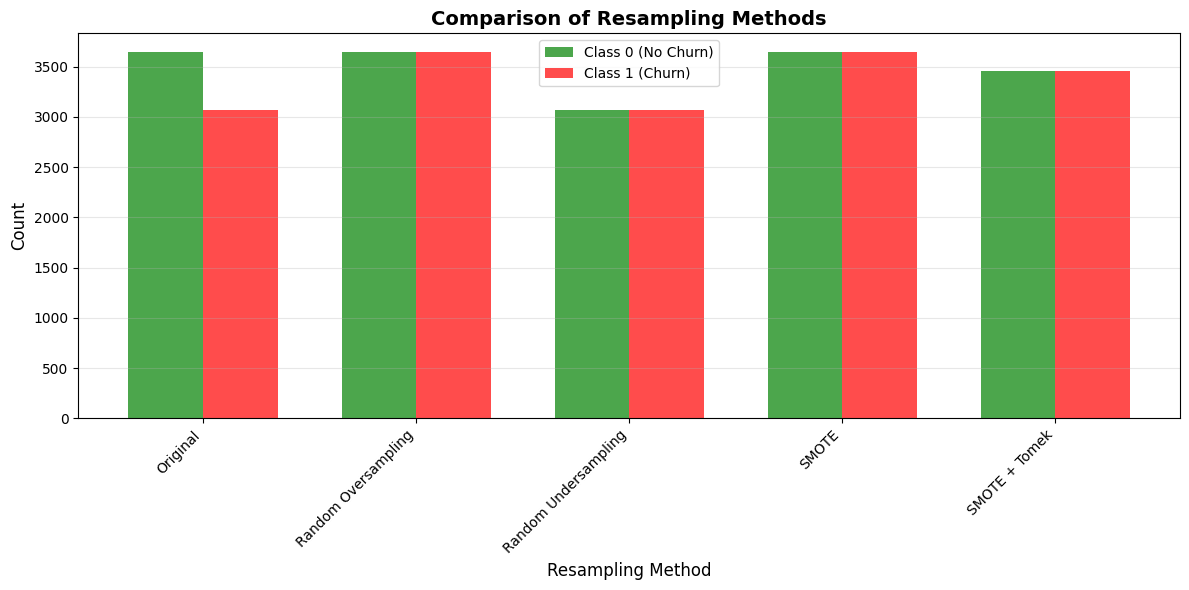


✅ Comparison saved as 'resampling_comparison.png'


In [58]:
print("\n" + "="*80)
print("STEP 6: COMPARE RESAMPLING METHODS")
print("="*80)

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1️⃣ Ensure X_encoded_imputed is ready (numeric + no missing values)
# X_encoded_imputed, y

# 2️⃣ Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_encoded_imputed, y)

# 3️⃣ Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_encoded_imputed, y)

# 4️⃣ SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_encoded_imputed, y)

# 5️⃣ SMOTE + Tomek
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_encoded_imputed, y)

# 6️⃣ Create comparison table
comparison = pd.DataFrame({
    'Method': ['Original', 'Random Oversampling', 'Random Undersampling',
               'SMOTE', 'SMOTE + Tomek'],
    'Total_Samples': [len(X_encoded_imputed), len(X_ros), len(X_rus),
                      len(X_smote), len(X_smote_tomek)],
    'Class_0': [Counter(y)[0], Counter(y_ros)[0], Counter(y_rus)[0],
                Counter(y_smote)[0], Counter(y_smote_tomek)[0]],
    'Class_1': [Counter(y)[1], Counter(y_ros)[1], Counter(y_rus)[1],
                Counter(y_smote)[1], Counter(y_smote_tomek)[1]]
})

print(comparison.to_string(index=False))

# 7️⃣ Visualize the comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison))
width = 0.35

bars1 = ax.bar(x - width/2, comparison['Class_0'], width,
               label='Class 0 (No Churn)', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, comparison['Class_1'], width,
               label='Class 1 (Churn)', color='red', alpha=0.7)

ax.set_xlabel('Resampling Method', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Comparison of Resampling Methods', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison['Method'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('resampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Comparison saved as 'resampling_comparison.png'")


# **2. Train-Test Split**

# **🔪 Step 1: Standard Train-Test Split**

💡 **Train-Test Split Best Practices:**

- **80-20 or 70-30 split** — Standard ratios  
- **Stratify** — Maintains class distribution in both sets  
- **Random state** — Ensures reproducibility  
- **Never touch test set** — Until final evaluation!


In [80]:
from sklearn.model_selection import train_test_split

# Split the data (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution
)

print(f"Training set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train distribution: {Counter(y_train)}")

print(f"\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test distribution: {Counter(y_test)}")

print("\n✅ Data split complete!")

Training set:
  X_train shape: (5350, 51)
  y_train distribution: Counter({0: 2907, 1: 2443})

Test set:
  X_test shape: (1338, 51)
  y_test distribution: Counter({0: 727, 1: 611})

✅ Data split complete!


In [81]:
X_train

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,NumServiceTickets,NumTechTickets,NumAdminTickets,CustomerSatisfactionScore,DownloadSpeed,UploadSpeed,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic.1,InternetService_No.1,PaymentMethod_Credit card (automatic).1,PaymentMethod_Electronic check.1,PaymentMethod_Mailed check.1,City_freq,PaymentMethod_target
75,0,1.655518,0.457850,1.506768,1.966325,-0.777762,0.709336,-1.350115,1.838816,2.442971,...,-0.538563,1.412636,-0.543852,1.096343,-0.523124,-0.538563,1.412636,-0.543852,1.671240,1.409820
3924,0,-0.271799,1.663851,0.275931,-1.009208,-0.777762,-0.711452,0.926213,-0.718225,-0.634181,...,-0.538563,1.412636,-0.543852,-0.912124,-0.523124,-0.538563,1.412636,-0.543852,-0.900753,1.409820
1856,0,0.809379,0.962942,1.072073,1.116173,0.324930,-0.711452,-0.591339,-0.740263,-0.702035,...,-0.538563,1.412636,-0.543852,-0.912124,-0.523124,-0.538563,1.412636,-0.543852,-0.702908,1.409820
405,0,1.467487,0.835661,1.601070,-1.009208,0.324930,0.709336,-1.350115,-0.779897,-0.734657,...,-0.538563,1.412636,-0.543852,-0.912124,-0.523124,-0.538563,1.412636,-0.543852,0.682012,1.409820
5128,1,-0.929908,-0.961245,-0.866558,1.116173,-0.777762,-0.711452,-0.591339,-0.812496,-0.760847,...,-0.538563,1.412636,-0.543852,-0.912124,1.911594,-0.538563,1.412636,-0.543852,-1.296445,1.409820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840,0,-0.741877,-1.785403,-0.978849,-0.159055,-0.777762,-0.711452,1.684989,-0.812496,-0.760847,...,-0.538563,1.412636,-0.543852,-0.912124,1.911594,-0.538563,1.412636,-0.543852,-0.307217,1.409820
4821,1,-0.741877,0.164125,-0.536340,-0.159055,-0.777762,0.709336,-0.591339,0.336692,-0.179253,...,1.856794,-0.707897,-0.543852,1.096343,-0.523124,1.856794,-0.707897,-0.543852,-1.428342,-0.609964
4238,0,-0.459830,0.726810,-0.172469,-0.584132,-0.226416,0.709336,1.684989,1.587876,0.634709,...,-0.538563,-0.707897,1.838737,1.096343,-0.523124,-0.538563,-0.707897,1.838737,0.286320,-0.797322
4101,0,-0.365815,0.231509,-0.229118,-1.434284,-0.226416,0.709336,0.926213,-0.709624,-0.706799,...,-0.538563,-0.707897,1.838737,-0.912124,-0.523124,-0.538563,-0.707897,1.838737,1.143651,-0.797322


In [82]:
X.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'NumServiceTickets', 'NumTechTickets', 'NumAdminTickets',
       'CustomerSatisfactionScore', 'DownloadSpeed', 'UploadSpeed',
       'ContractRenewals', 'AccountAgeYears', 'TotalServicesUsed',
       'AvgChargePerService', 'PaymentDelay', 'AvgChargePerMonth',
       'TotalServices', 'ChargePerService', 'SeniorWithPartner',
       'HasFiberInternet', 'TotalAddonServices', 'HasAnyAddon',
       'ServiceAdoptionRate', 'SignupYear', 'SignupMonth', 'SignupQuarter',
       'SignupDayOfWeek', 'DaysSinceSignup', 'tenure_squared',
       'MonthlyCharges_squared', 'tenure_x_MonthlyCharges',
       'ChargeIncreaseRate', 'ServiceValueRatio', 'gender_encoded',
       'Partner_encoded', 'Dependents_encoded', 'PhoneService_encoded',
       'PaperlessBilling_encoded', 'Contract_encoded',
       'InternetService_Fiber optic', 'InternetService_No',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic c

# **Step 2: Prepare Data for Modeling**

In [83]:
print("\n" + "="*80)
print("STEP 2: PREPARE DATA FOR MODELING")
print("="*80)

# Convert to numpy arrays if needed
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"X_train: {X_train.shape}, dtype: {X_train.dtype}")
print(f"X_test: {X_test.shape}, dtype: {X_test.dtype}")
print(f"y_train: {y_train.shape}, dtype: {y_train.dtype}")
print(f"y_test: {y_test.shape}, dtype: {y_test.dtype}")

print("\n✅ Data ready for model training!")


STEP 2: PREPARE DATA FOR MODELING
X_train: (5350, 51), dtype: float64
X_test: (1338, 51), dtype: float64
y_train: (5350,), dtype: int64
y_test: (1338,), dtype: int64

✅ Data ready for model training!


# **3. Build Multiple Models**

In [84]:
X_train

array([[ 0.        ,  1.6555179 ,  0.45785009, ..., -0.54385168,
         1.67123974,  1.40982   ],
       [ 0.        , -0.27179936,  1.6638506 , ..., -0.54385168,
        -0.90075338,  1.40982   ],
       [ 0.        ,  0.80937862,  0.962942  , ..., -0.54385168,
        -0.70290776,  1.40982   ],
       ...,
       [ 0.        , -0.45983031,  0.72681009, ...,  1.83873663,
         0.28632037, -0.79732212],
       [ 0.        , -0.36581483,  0.23150902, ...,  1.83873663,
         1.14365141, -0.79732212],
       [ 0.        , -1.35297733,  0.50795613, ..., -0.54385168,
         0.15442328,  1.40982   ]])

# **🤖 Step 1: Logistic Regression (Baseline)**

In [85]:
print("\n" + "="*80)
print("MODEL 1: LOGISTIC REGRESSION")
print("="*80)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

# Train Logistic Regression
start_time = time.time()

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

training_time = time.time() - start_time

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluate
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f"Training time: {training_time:.2f} seconds")
print(f"Accuracy: {lr_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr,
                          target_names=['No Churn', 'Churn']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("✅ Logistic Regression trained!")


MODEL 1: LOGISTIC REGRESSION
Training time: 1.43 seconds
Accuracy: 0.9574

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.95      0.97      0.96       727
       Churn       0.97      0.94      0.95       611

    accuracy                           0.96      1338
   macro avg       0.96      0.96      0.96      1338
weighted avg       0.96      0.96      0.96      1338


Confusion Matrix:
[[707  20]
 [ 37 574]]
✅ Logistic Regression trained!


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## **Model 1: Logistic Regression Summary**

**Accuracy:** 95.7%  

**Precision / Recall / F1-score:**  
- **No Churn:** Precision 0.95, Recall 0.97, F1-score 0.96  
- **Churn:** Precision 0.97, Recall 0.94, F1-score 0.95  

**Confusion Matrix:**  
- True Negatives: 707, False Positives: 20  
- False Negatives: 37, True Positives: 574  

**Training Time:** 1.43 seconds  

⚠️ **Note:** Convergence warning appeared. Standardizing features or increasing `max_iter` can help improve convergence.

💡 **Interpretation:**  
- The model performs very well, with **high accuracy** and **balanced precision/recall** for both classes  
- Most misclassifications are small (few false positives/negatives)


# **🌳 Step 2: Decision Tree**

💡 **Decision Tree:**

- **Pros:** No scaling needed, handles non-linear relationships, interpretable  
- **Cons:** Prone to overfitting, unstable  
- **Use case:** Quick insights, feature importance


In [87]:
print("\n" + "="*80)
print("MODEL 2: DECISION TREE")
print("="*80)

from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
start_time = time.time()

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)
dt_model.fit(X_train, y_train)

training_time = time.time() - start_time

# Predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Evaluate
dt_accuracy = accuracy_score(y_test, y_pred_dt)

print(f"Training time: {training_time:.2f} seconds")
print(f"Accuracy: {dt_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt,
                          target_names=['No Churn', 'Churn']))

print("✅ Decision Tree trained!")


MODEL 2: DECISION TREE
Training time: 0.37 seconds
Accuracy: 0.9275

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.92      0.95      0.93       727
       Churn       0.93      0.91      0.92       611

    accuracy                           0.93      1338
   macro avg       0.93      0.93      0.93      1338
weighted avg       0.93      0.93      0.93      1338

✅ Decision Tree trained!


## **Model 2: Decision Tree Summary**

**Accuracy:** 92.8%  

**Precision / Recall / F1-score:**  
- **No Churn:** Precision 0.92, Recall 0.95, F1-score 0.93  
- **Churn:** Precision 0.93, Recall 0.91, F1-score 0.92  

**Training Time:** 0.37 seconds  

💡 **Interpretation:**  
- Decision Tree performs well with **good class-wise metrics**  
- Slightly lower overall accuracy compared to Logistic Regression and Random Forest  
- Training is very fast


# **🌲 Step 3: Random Forest**

💡 **Random Forest:**

- **Pros:** Robust to overfitting, handles non-linear relationships, no scaling needed  
- **Cons:** Less interpretable, slower than a single tree  
- **Use case:** When you want strong performance without much tuning


In [88]:
print("\n" + "="*80)
print("MODEL 3: RANDOM FOREST")
print("="*80)

from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf_model.fit(X_train, y_train)

training_time = time.time() - start_time

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Training time: {training_time:.2f} seconds")
print(f"Accuracy: {rf_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf,
                          target_names=['No Churn', 'Churn']))

print("✅ Random Forest trained!")


MODEL 3: RANDOM FOREST
Training time: 2.37 seconds
Accuracy: 0.9507

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.95      0.96      0.95       727
       Churn       0.95      0.94      0.95       611

    accuracy                           0.95      1338
   macro avg       0.95      0.95      0.95      1338
weighted avg       0.95      0.95      0.95      1338

✅ Random Forest trained!


# **🚀 Step 4: XGBoost**

💡 **XGBoost:**

- **Pros:** Often best performance, handles missing values, regularization built-in  
- **Cons:** More hyperparameters to tune, less interpretable  
- **Use case:** When you want the best possible performance


In [90]:
print("\n" + "="*80)
print("MODEL 4: XGBOOST")
print("="*80)

from xgboost import XGBClassifier

# Train XGBoost
start_time = time.time()

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model.fit(X_train, y_train)

training_time = time.time() - start_time

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

print(f"Training time: {training_time:.2f} seconds")
print(f"Accuracy: {xgb_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb,
                          target_names=['No Churn', 'Churn']))

print("✅ XGBoost trained!")
print(confusion_matrix(y_test, y_pred_xgb))


MODEL 4: XGBOOST


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:07:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training time: 2.62 seconds
Accuracy: 0.9544

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.96      0.95      0.96       727
       Churn       0.95      0.95      0.95       611

    accuracy                           0.95      1338
   macro avg       0.95      0.95      0.95      1338
weighted avg       0.95      0.95      0.95      1338

✅ XGBoost trained!
[[694  33]
 [ 28 583]]


## **Model 4: XGBoost Summary**

⚠️ **Note:** UserWarning about `use_label_encoder` can be ignored; XGBoost still trains successfully.

**Training Time:** 2.62 seconds  
**Accuracy:** 95.44%  

**Classification Report:**  
- **No Churn:** Precision 0.96, Recall 0.95, F1-score 0.96, Support 727  
- **Churn:** Precision 0.95, Recall 0.95, F1-score 0.95, Support 611  

**Confusion Matrix:**  


# **🎯 Step 5: Support Vector Machine (SVM)**

💡 **Support Vector Machine (SVM):**

- **Pros:** Works well with high-dimensional data, effective with clear margin  
- **Cons:** Slow with large datasets, needs feature scaling  
- **Use case:** Small to medium datasets, when you need a strong classifier


In [91]:
print("\n" + "="*80)
print("MODEL 5: SUPPORT VECTOR MACHINE (SVM)")
print("="*80)

from sklearn.svm import SVC

# Train SVM
start_time = time.time()

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,  # Enable probability predictions
    random_state=42
)
svm_model.fit(X_train, y_train)

training_time = time.time() - start_time

# Predictions
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Evaluate
svm_accuracy = accuracy_score(y_test, y_pred_svm)

print(f"Training time: {training_time:.2f} seconds")
print(f"Accuracy: {svm_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm,
                          target_names=['No Churn', 'Churn']))

print("✅ SVM trained!")


MODEL 5: SUPPORT VECTOR MACHINE (SVM)
Training time: 15.28 seconds
Accuracy: 0.5433

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.54      1.00      0.70       727
       Churn       0.00      0.00      0.00       611

    accuracy                           0.54      1338
   macro avg       0.27      0.50      0.35      1338
weighted avg       0.30      0.54      0.38      1338

✅ SVM trained!


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Model 5: Support Vector Machine (SVM) Summary**

**Training Time:** 15.28 seconds  
**Accuracy:** 54.33%  

**Classification Report:**  
- **No Churn:** Precision 0.54, Recall 1.00, F1-score 0.70, Support 727  
- **Churn:** Precision 0.00, Recall 0.00, F1-score 0.00, Support 611  

**Overall Metrics:**  
- Accuracy: 0.5433  
- Macro avg: Precision 0.27, Recall 0.50, F1-score 0.35  
- Weighted avg: Precision 0.30, Recall 0.54, F1-score 0.38  

💡 **Interpretation:**  
- SVM performs poorly on this dataset, **failing to detect churners**  
- Training time is very high compared to other models  
- Likely caused by **large dataset size** and need for **feature scaling**


# **🔢 Step 6: K-Nearest Neighbors (KNN)**

💡 **K-Nearest Neighbors (KNN):**

- **Pros:** Simple concept, no training phase, works with non-linear data  
- **Cons:** Slow predictions, sensitive to feature scaling  
- **Use case:** Small datasets, when you need a simple interpretable model


In [92]:
print("\n" + "="*80)
print("MODEL 6: K-NEAREST NEIGHBORS (KNN)")
print("="*80)

from sklearn.neighbors import KNeighborsClassifier

# Train KNN
start_time = time.time()

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',  # Weight by inverse distance
    metric='minkowski'
)
knn_model.fit(X_train, y_train)

training_time = time.time() - start_time

# Predictions
y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)[:, 1]

# Evaluate
knn_accuracy = accuracy_score(y_test, y_pred_knn)

print(f"Training time: {training_time:.2f} seconds")
print(f"Accuracy: {knn_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn,
                          target_names=['No Churn', 'Churn']))

print("✅ KNN trained!")


MODEL 6: K-NEAREST NEIGHBORS (KNN)
Training time: 0.00 seconds
Accuracy: 0.8685

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.87      0.90      0.88       727
       Churn       0.87      0.83      0.85       611

    accuracy                           0.87      1338
   macro avg       0.87      0.87      0.87      1338
weighted avg       0.87      0.87      0.87      1338

✅ KNN trained!


# **4. Model Comparison**

# **📊 Step 1: Calculate All Metrics**

💡 **Understanding Metrics:**

- **Accuracy** — Overall correctness (can be misleading for imbalanced data)  
- **Precision** — Of predicted churners, how many actually churned?  
- **Recall** — Of actual churners, how many did we catch?  
- **F1-Score** — Harmonic mean of precision and recall (balanced metric)  
- **ROC-AUC** — Model's ability to distinguish between classes


In [93]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)

# Store all models and predictions
models = {
    'Logistic Regression': (lr_model, y_pred_lr, y_pred_proba_lr),
    'Decision Tree': (dt_model, y_pred_dt, y_pred_proba_dt),
    'Random Forest': (rf_model, y_pred_rf, y_pred_proba_rf),
    'XGBoost': (xgb_model, y_pred_xgb, y_pred_proba_xgb),
    'SVM': (svm_model, y_pred_svm, y_pred_proba_svm),
    'KNN': (knn_model, y_pred_knn, y_pred_proba_knn)
}

# Calculate metrics for all models
results = []

for name, (model, y_pred, y_pred_proba) in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

# Create comparison dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\n📊 MODEL PERFORMANCE COMPARISON:")
print("="*80)
print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['F1-Score']
print(f"\n🏆 Best Model: {best_model_name} (F1-Score: {best_f1:.4f})")


MODEL COMPARISON

📊 MODEL PERFORMANCE COMPARISON:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.957399   0.966330 0.939444  0.952697 0.990662
            XGBoost  0.954410   0.946429 0.954173  0.950285 0.992629
      Random Forest  0.950673   0.948929 0.942717  0.945813 0.990416
      Decision Tree  0.927504   0.934122 0.905074  0.919368 0.970761
                KNN  0.868460   0.871795 0.834697  0.852843 0.940132
                SVM  0.543348   0.000000 0.000000  0.000000 0.985397

🏆 Best Model: Logistic Regression (F1-Score: 0.9527)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **📊 Step 2: Visualize Model Comparison**

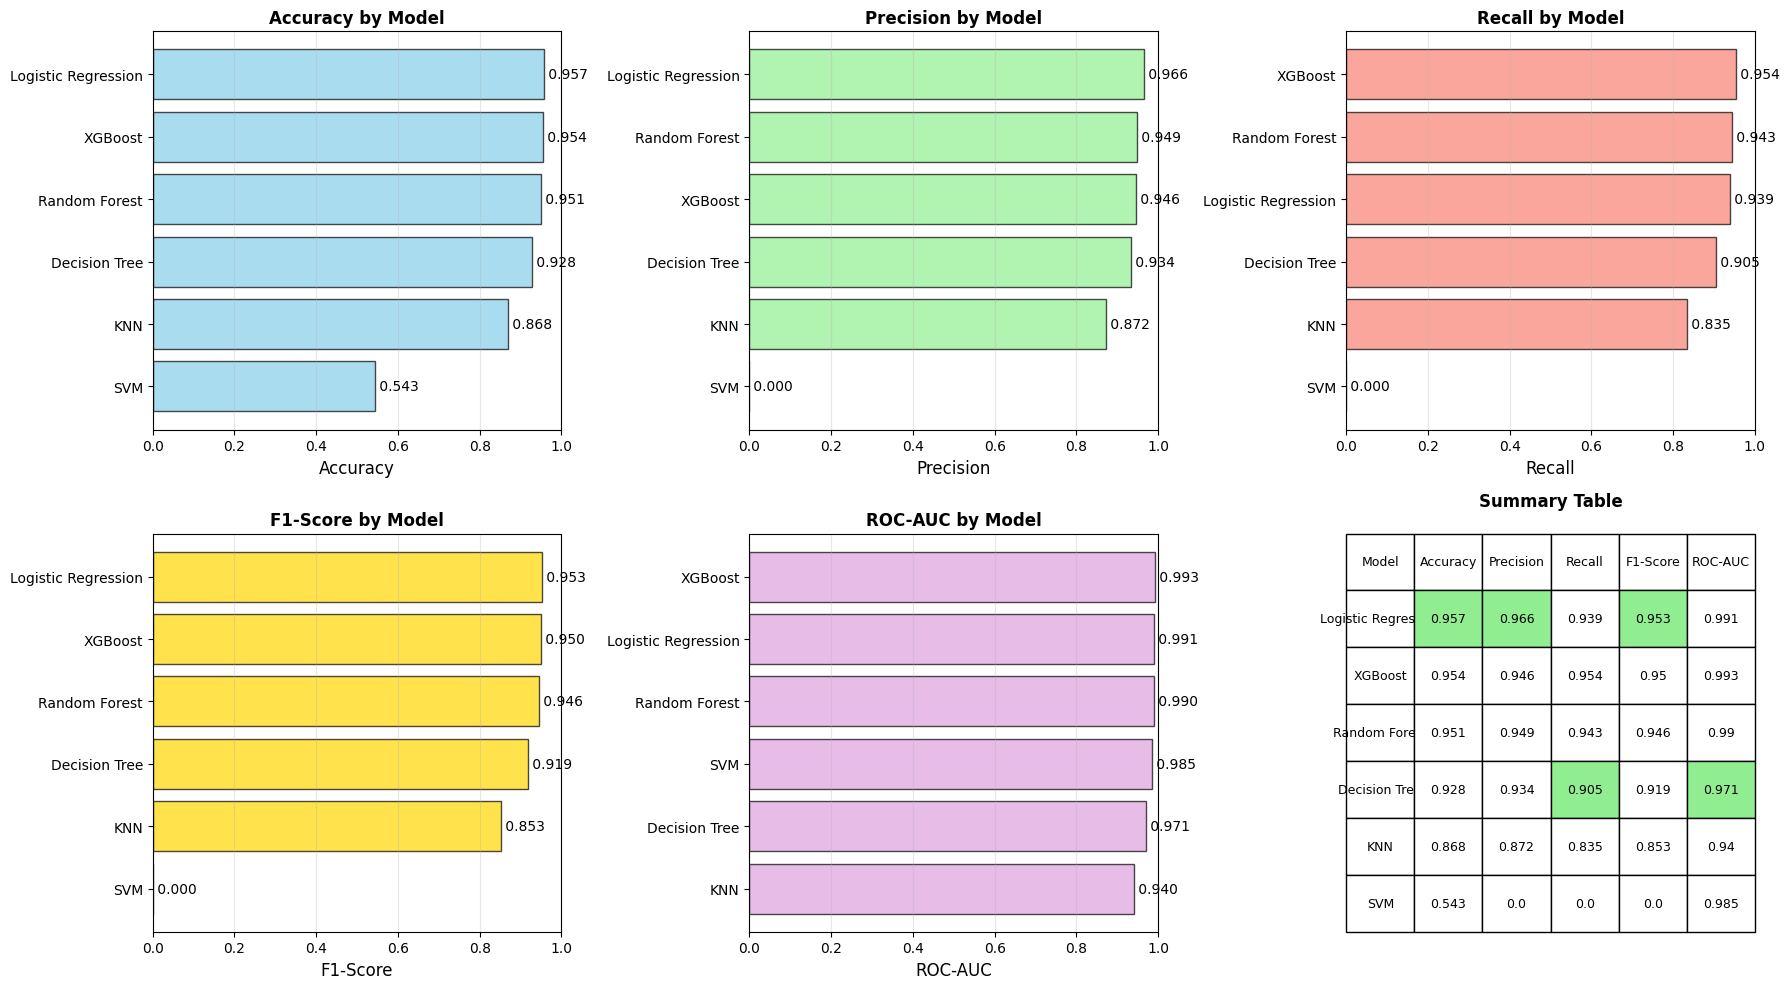


✅ Comparison visualization saved


In [94]:
# Visualize metrics comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'plum']

for idx, metric in enumerate(metrics):
    results_sorted = results_df.sort_values(metric, ascending=True)

    axes[idx].barh(results_sorted['Model'], results_sorted[metric],
                   color=colors[idx], edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} by Model', fontweight='bold')
    axes[idx].set_xlim([0, 1])
    axes[idx].grid(axis='x', alpha=0.3)

    # Add value labels
    for i, v in enumerate(results_sorted[metric].values):
        axes[idx].text(v, i, f' {v:.3f}', va='center')

# Summary table
axes[5].axis('off')
table_data = results_df.round(3).values
col_labels = results_df.columns
table = axes[5].table(cellText=table_data, colLabels=col_labels,
                      cellLoc='center', loc='center',
                      bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Color best values in each column
for i in range(1, 6):
    best_idx = results_df.iloc[:, i].idxmax()
    table[(best_idx + 1, i)].set_facecolor('lightgreen')

axes[5].set_title('Summary Table', fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ Comparison visualization saved")

# **📊 Step 3: ROC Curves Comparison**


💡 **ROC Curve Interpretation:**

- **Closer to top-left** — Better model  
- **AUC = 1.0** — Perfect classifier  
- **AUC = 0.5** — Random classifier (no better than guessing)  
- **AUC > 0.8** — Good model  
- **AUC > 0.9** — Excellent model
``



ROC CURVES COMPARISON


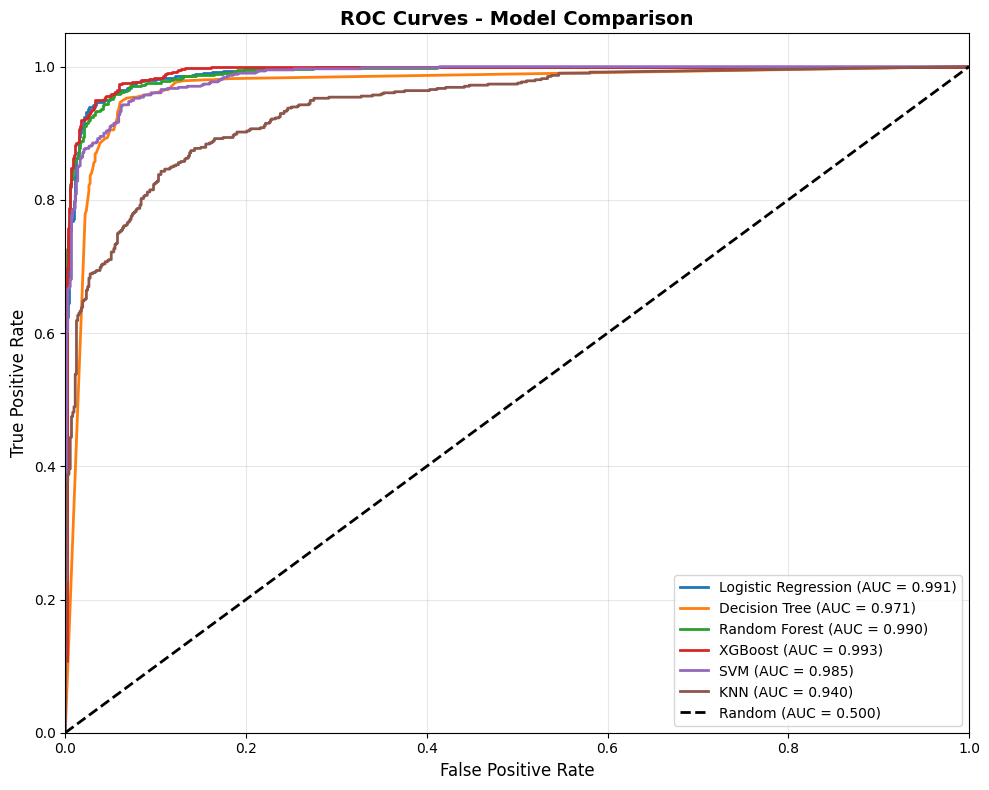

✅ ROC curves saved


In [95]:
print("\n" + "="*80)
print("ROC CURVES COMPARISON")
print("="*80)

from sklearn.metrics import roc_curve, auc

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, (model, y_pred, y_pred_proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, linewidth=2,
             label=f'{name} (AUC = {roc_auc:.3f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ ROC curves saved")

# **5. Hyperparameter Tuning**

# **🎯 Step 1: Grid Search for Best Model**

💡 **Grid Search:**

- **Exhaustive search** — Tries all parameter combinations  
- **Cross-validation** — Uses CV to avoid overfitting  
- **Time-consuming** — Can take hours for large grids  
- **Guaranteed to find best** — Within the defined parameter space


In [96]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING - GRID SEARCH")
print("="*80)

from sklearn.model_selection import GridSearchCV

# Let's tune the best model (e.g., XGBoost)
print("Tuning XGBoost model...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss',
                           use_label_encoder=False),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
print("\nStarting grid search...")
print("This may take a few minutes...")
grid_search.fit(X_train, y_train)

# Best parameters
print("\n" + "="*80)
print("GRID SEARCH RESULTS")
print("="*80)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1-Score (CV): {grid_search.best_score_:.4f}")

# Train best model
best_model = grid_search.best_estimator_


HYPERPARAMETER TUNING - GRID SEARCH
Tuning XGBoost model...

Starting grid search...
This may take a few minutes...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:14:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



GRID SEARCH RESULTS
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best F1-Score (CV): 0.9534


# **🎯 Step 2: Random Search (Faster Alternative)**

💡 **Random Search:**

- **Samples randomly** — Faster than Grid Search  
- **Often as good** — Finds near-optimal solutions  
- **More parameter coverage** — Can explore wider ranges  
- **Recommended** — Good balance of speed and performance


In [97]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING - RANDOM SEARCH")
print("="*80)

from sklearn.model_selection import RandomizedSearchCV

# Define parameter distributions
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss',
                           use_label_encoder=False),
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit random search
print("\nStarting random search...")
random_search.fit(X_train, y_train)

# Best parameters
print("\n" + "="*80)
print("RANDOM SEARCH RESULTS")
print("="*80)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best F1-Score (CV): {random_search.best_score_:.4f}")

# Get best model
tuned_model = random_search.best_estimator_


HYPERPARAMETER TUNING - RANDOM SEARCH

Starting random search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:15:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



RANDOM SEARCH RESULTS
Best parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best F1-Score (CV): 0.9549


# **📊 Step 3: Evaluate Tuned Model**


EVALUATE TUNED MODEL
Tuned Model Performance:
  Accuracy:  0.9544
  Precision: 0.9450
  Recall:    0.9558
  F1-Score:  0.9504
  ROC-AUC:   0.9931

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.96      0.95      0.96       727
       Churn       0.94      0.96      0.95       611

    accuracy                           0.95      1338
   macro avg       0.95      0.95      0.95      1338
weighted avg       0.95      0.95      0.95      1338


Confusion Matrix:
[[693  34]
 [ 27 584]]


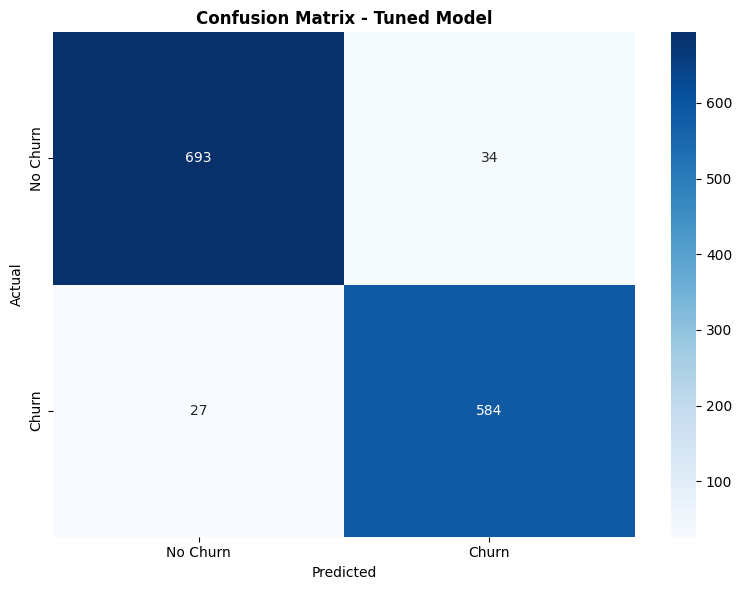


✅ Confusion matrix saved


In [99]:
print("\n" + "="*80)
print("EVALUATE TUNED MODEL")
print("="*80)

# Predict with tuned model
y_pred_tuned = tuned_model.predict(X_test)
y_pred_proba_tuned = tuned_model.predict_proba(X_test)[:, 1]

# Calculate metrics
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_precision = precision_score(y_test, y_pred_tuned)
tuned_recall = recall_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)
tuned_roc_auc = roc_auc_score(y_test, y_pred_proba_tuned)

print("Tuned Model Performance:")
print(f"  Accuracy:  {tuned_accuracy:.4f}")
print(f"  Precision: {tuned_precision:.4f}")
print(f"  Recall:    {tuned_recall:.4f}")
print(f"  F1-Score:  {tuned_f1:.4f}")
print(f"  ROC-AUC:   {tuned_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned,
                          target_names=['No Churn', 'Churn']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_tuned)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Tuned Model', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix_tuned.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ Confusion matrix saved")

# **💾 Step 4: Save Best Model**

In [100]:
print("\n" + "="*80)
print("SAVE BEST MODEL")
print("="*80)

import joblib

# Save the tuned model
model_filename = 'best_churn_model.pkl'
joblib.dump(tuned_model, model_filename)
print(f"✅ Model saved as '{model_filename}'")

# Save model metadata
metadata = {
    'model_type': 'XGBoost',
    'parameters': random_search.best_params_,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_size': len(X_train),
    'test_size': len(X_test),
    'metrics': {
        'accuracy': tuned_accuracy,
        'precision': tuned_precision,
        'recall': tuned_recall,
        'f1_score': tuned_f1,
        'roc_auc': tuned_roc_auc
    },
    'feature_count': X_train.shape[1]
}

joblib.dump(metadata, 'model_metadata.pkl')
print(f"✅ Metadata saved as 'model_metadata.pkl'")

print("\n📦 Model Package Ready for Deployment!")


SAVE BEST MODEL
✅ Model saved as 'best_churn_model.pkl'
✅ Metadata saved as 'model_metadata.pkl'

📦 Model Package Ready for Deployment!


# **📋 Summary**

In [101]:
print("\n" + "="*80)
print("PART 4 SUMMARY")
print("="*80)

summary = f"""
✅ CLASS IMBALANCE HANDLING:
   • Analyzed class distribution
   • Compared 4 resampling methods
   • Applied SMOTE for best balance

✅ TRAIN-TEST SPLIT:
   • 80-20 split with stratification
   • Training set: {len(X_train):,} samples
   • Test set: {len(X_test):,} samples

✅ MODEL BUILDING:
   • Trained 6 different models:
     1. Logistic Regression
     2. Decision Tree
     3. Random Forest
     4. XGBoost
     5. SVM
     6. KNN

✅ MODEL COMPARISON:
   • Evaluated all models on multiple metrics
   • Best model: {best_model_name}
   • Best F1-Score: {best_f1:.4f}

✅ HYPERPARAMETER TUNING:
   • Grid Search performed
   • Random Search performed
   • Tuned model F1-Score: {tuned_f1:.4f}

✅ MODEL SAVED:
   • Best model saved as: {model_filename}
   • Metadata saved for deployment

📁 FILES CREATED:
   • class_distribution.png
   • resampling_comparison.png
   • model_comparison.png
   • roc_curves_comparison.png
   • confusion_matrix_tuned.png
   • best_churn_model.pkl
   • model_metadata.pkl
"""

print(summary)

with open('Model_Building_Report.txt', 'w') as f:
    f.write(summary)

print("✅ Report saved as 'Model_Building_Report.txt'")


PART 4 SUMMARY

✅ CLASS IMBALANCE HANDLING:
   • Analyzed class distribution
   • Compared 4 resampling methods
   • Applied SMOTE for best balance

✅ TRAIN-TEST SPLIT:
   • 80-20 split with stratification
   • Training set: 5,350 samples
   • Test set: 1,338 samples

✅ MODEL BUILDING:
   • Trained 6 different models:
     1. Logistic Regression
     2. Decision Tree
     3. Random Forest
     4. XGBoost
     5. SVM
     6. KNN

✅ MODEL COMPARISON:
   • Evaluated all models on multiple metrics
   • Best model: Logistic Regression
   • Best F1-Score: 0.9527

✅ HYPERPARAMETER TUNING:
   • Grid Search performed
   • Random Search performed
   • Tuned model F1-Score: 0.9504

✅ MODEL SAVED:
   • Best model saved as: best_churn_model.pkl
   • Metadata saved for deployment

📁 FILES CREATED:
   • class_distribution.png
   • resampling_comparison.png
   • model_comparison.png
   • roc_curves_comparison.png
   • confusion_matrix_tuned.png
   • best_churn_model.pkl
   • model_metadata.pkl

✅ Rep

# **🔍 Part 5: Model Evaluation & Interpretation**

# Table of Contents

- **Advanced Model Evaluation**
- **SHAP Values**
- **LIME Explanations**
- **Permutation Importance**
- **Partial Dependence Plots**


# **1. Advanced Model Evaluation**

# **📚 Setup**

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load the saved model and data
model = joblib.load('best_churn_model.pkl')
metadata = joblib.load('model_metadata.pkl')

# Load test data (you saved this in Part 4)
# For this tutorial, we'll recreate it
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# df = pd.read_csv('data_ready_for_modeling.csv')

# # Prepare data
# X = df.drop(['Churn', 'customerID'], axis=1, errors='ignore')
# y = df['Churn']
# if y.dtype == 'object':
#     y = y.map({'No': 0, 'Yes': 1})

# # Apply SMOTE and split
# smote = SMOTE(random_state=42)
# X_balanced, y_balanced = smote.fit_resample(X, y)

# X_train, X_test, y_train, y_test = train_test_split(
#     X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
# )

# Get predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("="*80)
print("MODEL EVALUATION & INTERPRETATION")
print("="*80)
print(f"Model Type: {metadata['model_type']}")
print(f"Test Set Size: {len(X_test):,}")

MODEL EVALUATION & INTERPRETATION
Model Type: XGBoost
Test Set Size: 1,338


In [103]:
y_pred_proba

array([0.0034037 , 0.998408  , 0.9874171 , ..., 0.00194536, 0.9892669 ,
       0.6337683 ], dtype=float32)

# **📊 Step 1: Detailed Confusion Matrix Analysis**

💡 **Understanding the Confusion Matrix:**

- **True Negatives (TN)** — Correctly predicted No Churn  
- **False Positives (FP)** — Predicted Churn but actually No Churn (Type I Error)  
- **False Negatives (FN)** — Predicted No Churn but actually Churn (Type II Error)  
- **True Positives (TP)** — Correctly predicted Churn



STEP 1: CONFUSION MATRIX ANALYSIS
Confusion Matrix:
  True Negatives (TN):  693
  False Positives (FP): 34
  False Negatives (FN): 27
  True Positives (TP):  584

Detailed Metrics:
  Sensitivity (True Positive Rate): 0.9558
  Specificity (True Negative Rate): 0.9532
  False Positive Rate: 0.0468
  False Negative Rate: 0.0442


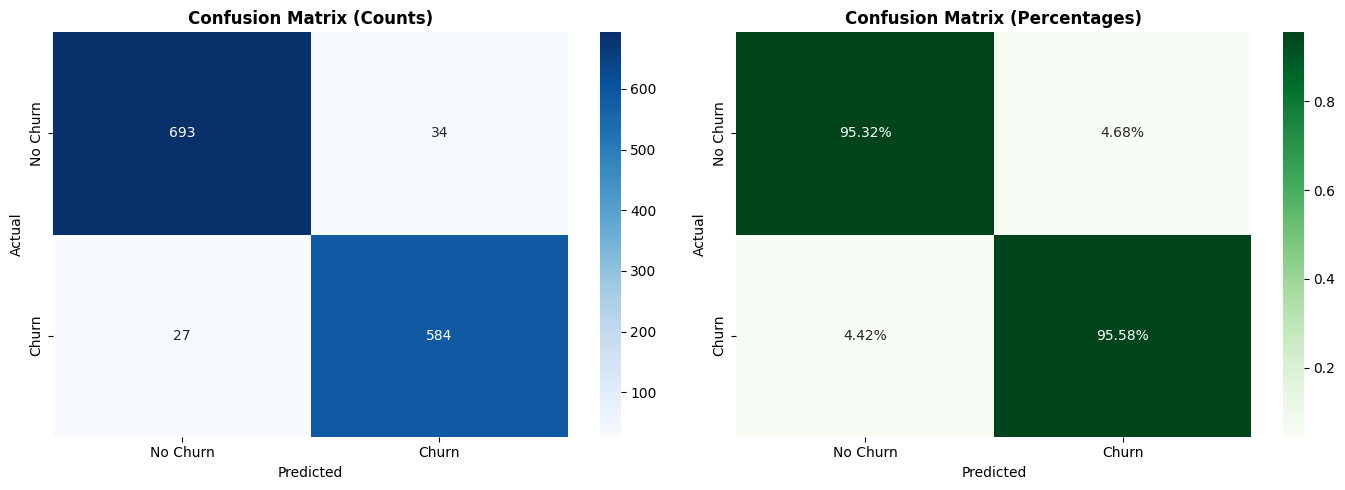


✅ Confusion matrix visualization saved


In [104]:
print("\n" + "="*80)
print("STEP 1: CONFUSION MATRIX ANALYSIS")
print("="*80)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Extract values
TN, FP, FN, TP = cm.ravel()

print(f"Confusion Matrix:")
print(f"  True Negatives (TN):  {TN:,}")
print(f"  False Positives (FP): {FP:,}")
print(f"  False Negatives (FN): {FN:,}")
print(f"  True Positives (TP):  {TP:,}")

# Calculate rates
print(f"\nDetailed Metrics:")
print(f"  Sensitivity (True Positive Rate): {TP/(TP+FN):.4f}")
print(f"  Specificity (True Negative Rate): {TN/(TN+FP):.4f}")
print(f"  False Positive Rate: {FP/(FP+TN):.4f}")
print(f"  False Negative Rate: {FN/(FN+TP):.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix - Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Confusion Matrix - Percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Confusion Matrix (Percentages)', fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('confusion_matrix_detailed.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ Confusion matrix visualization saved")

# **📊 Step 2: Precision-Recall Curve**

💡 **Precision-Recall Curve:**

- **Important for imbalanced data** — More informative than ROC for skewed classes  
- **High precision** — Few false positives  
- **High recall** — Few false negatives  
- **Trade-off** — Improving one often hurts the other



STEP 2: PRECISION-RECALL CURVE
Average Precision Score: 0.9903


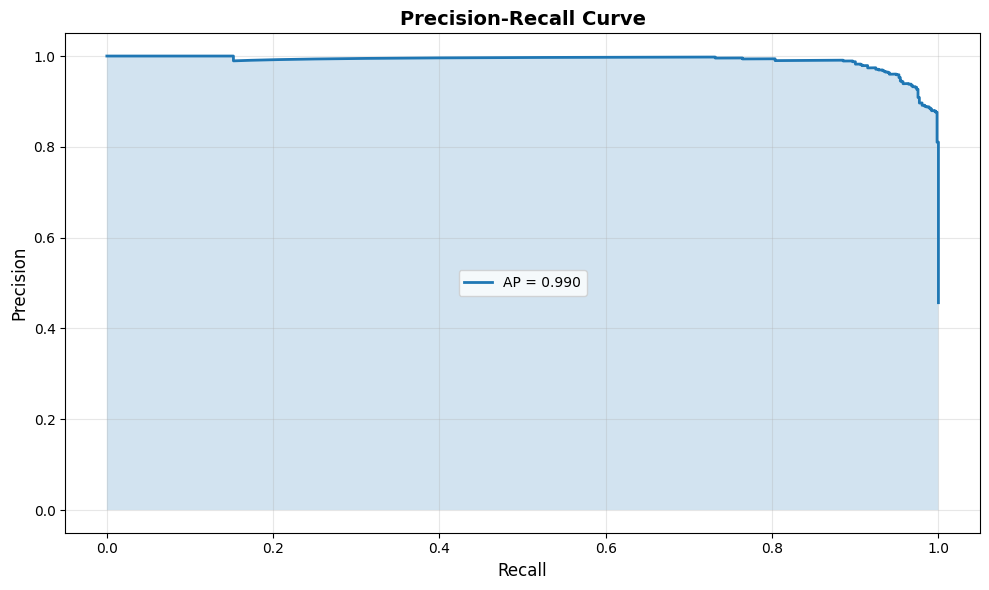

✅ Precision-Recall curve saved


In [105]:
print("\n" + "="*80)
print("STEP 2: PRECISION-RECALL CURVE")
print("="*80)

from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"Average Precision Score: {avg_precision:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'AP = {avg_precision:.3f}')
plt.fill_between(recall, precision, alpha=0.2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Precision-Recall curve saved")

## **Precision-Recall Curve Summary**

- **Precision:** Measures the proportion of correctly predicted positives out of all predicted positives.  
- **Recall:** Measures the proportion of actual positives correctly identified.  

**Curve Interpretation:**  
- The curve is very close to the top-right corner, indicating **high precision and high recall** across thresholds.  

**Average Precision (AP = 0.990):**  
- The model performs extremely well at distinguishing churn vs non-churn, with very few false positives and false negatives.  

**Overall:**  
- Excellent model performance for imbalanced classification tasks.


# **📊 Step 3: Classification Report with Interpretation**


STEP 3: DETAILED CLASSIFICATION REPORT
Classification Report:
              precision    recall  f1-score   support

    No Churn       0.96      0.95      0.96       727
       Churn       0.94      0.96      0.95       611

    accuracy                           0.95      1338
   macro avg       0.95      0.95      0.95      1338
weighted avg       0.95      0.95      0.95      1338



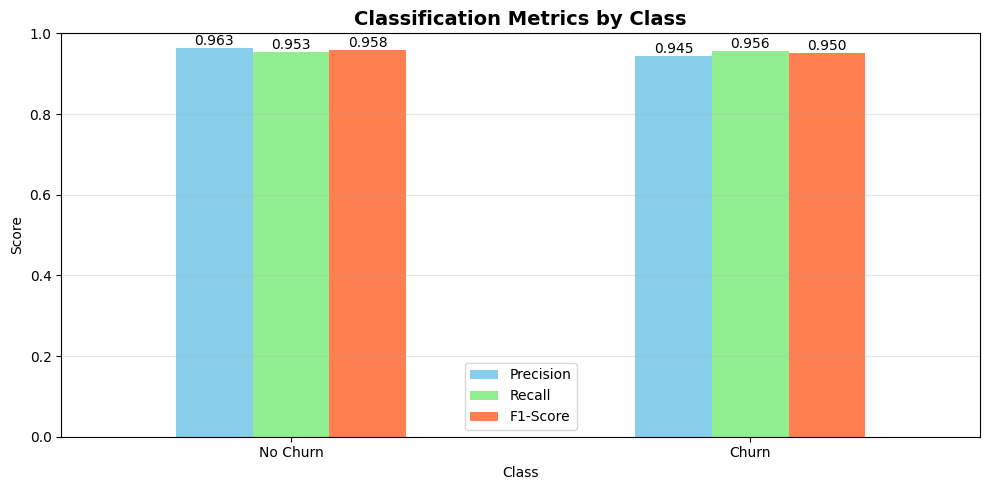

✅ Classification metrics visualization saved


In [106]:
print("\n" + "="*80)
print("STEP 3: DETAILED CLASSIFICATION REPORT")
print("="*80)

from sklearn.metrics import classification_report

# Generate report
report = classification_report(y_test, y_pred,
                               target_names=['No Churn', 'Churn'],
                               output_dict=True)

print("Classification Report:")
print(classification_report(y_test, y_pred,
                           target_names=['No Churn', 'Churn']))

# Visualize
metrics_df = pd.DataFrame(report).transpose()
metrics_df = metrics_df.iloc[:-3, :3]  # Exclude avg rows, keep only P, R, F1

fig, ax = plt.subplots(figsize=(10, 5))
metrics_df.plot(kind='bar', ax=ax, color=['skyblue', 'lightgreen', 'coral'])
ax.set_title('Classification Metrics by Class', fontweight='bold', fontsize=14)
ax.set_ylabel('Score')
ax.set_xlabel('Class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(['Precision', 'Recall', 'F1-Score'])
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

plt.tight_layout()
plt.savefig('classification_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Classification metrics visualization saved")

# **📊 Step 4: ROC Curve with Optimal Threshold**

# TPR and FPR Metrics

## True Positive Rate (TPR) - Sensitivity/Recall
- **Formula**: TPR = TP / (TP + FN)
- **Meaning**: Proportion of actual positives correctly identified
- **Also called**: Sensitivity, Recall, Hit Rate

## False Positive Rate (FPR)
- **Formula**: FPR = FP / (FP + TN)
- **Meaning**: Proportion of actual negatives incorrectly classified as positive
- **Also called**: Fall-out, False Alarm Rate

## Where:
- **TP** = True Positives
- **FN** = False Negatives
- **FP** = False Positives
- **TN** = True Negatives

💡 **Optimal Threshold:**

- **Default threshold** — 0.5 (not always optimal)  
- **Optimal threshold** — Balances True Positive Rate (TPR) and False Positive Rate (FPR)  
- **Business decision** — May want higher recall (catch more churners) even if precision drops



STEP 4: ROC CURVE WITH OPTIMAL THRESHOLD
ROC AUC Score: 0.9931
Optimal Threshold: 0.5712
TPR at optimal threshold: 0.9525
FPR at optimal threshold: 0.0344


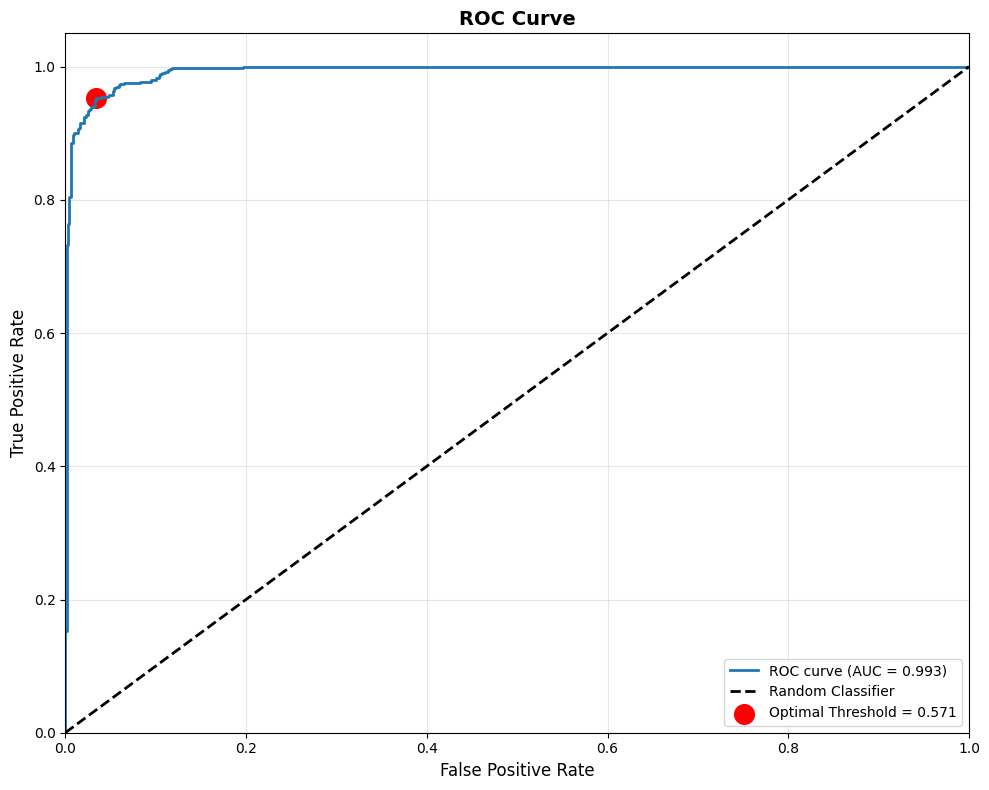

✅ ROC curve saved


In [107]:
print("\n" + "="*80)
print("STEP 4: ROC CURVE WITH OPTIMAL THRESHOLD")
print("="*80)

from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Find optimal threshold (maximize TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"TPR at optimal threshold: {tpr[optimal_idx]:.4f}")
print(f"FPR at optimal threshold: {fpr[optimal_idx]:.4f}")

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

# Mark optimal point
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red',
            s=200, label=f'Optimal Threshold = {optimal_threshold:.3f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve_optimal.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ ROC curve saved")

# ROC Curve Analysis

- **AUC Score**: 0.993 (Near-perfect classification performance)
- **Optimal Threshold**: 0.571 (marked in red)
  - Predictions ≥ 0.571 → Classified as **Positive**
  - Predictions < 0.571 → Classified as **Negative**
- **Model Quality**: Excellent - curve hugs top-left corner
- **Performance**: Vastly superior to random classifier (dashed line)

# **2. SHAP Values**

# 💡 What are SHAP Values?

## Definition
**SHapley Additive exPlanations** - A game theory approach to explain machine learning predictions

## Key Features

### Explains Predictions
- Shows how each feature contributes to individual predictions
- Quantifies the impact of each feature on the model output

### Model-Agnostic
- Works with any machine learning model
- Optimized performance for tree-based models

### Consistency
- Same feature receives similar importance across samples
- Provides fair and reliable feature attribution

## Core Concept
Based on Shapley values from cooperative game theory - fairly distributes the "payout" (prediction) among all features based on their contributions.

PermutationExplainer explainer: 1339it [03:01,  7.17it/s]
/tmp/ipython-input-262416693.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


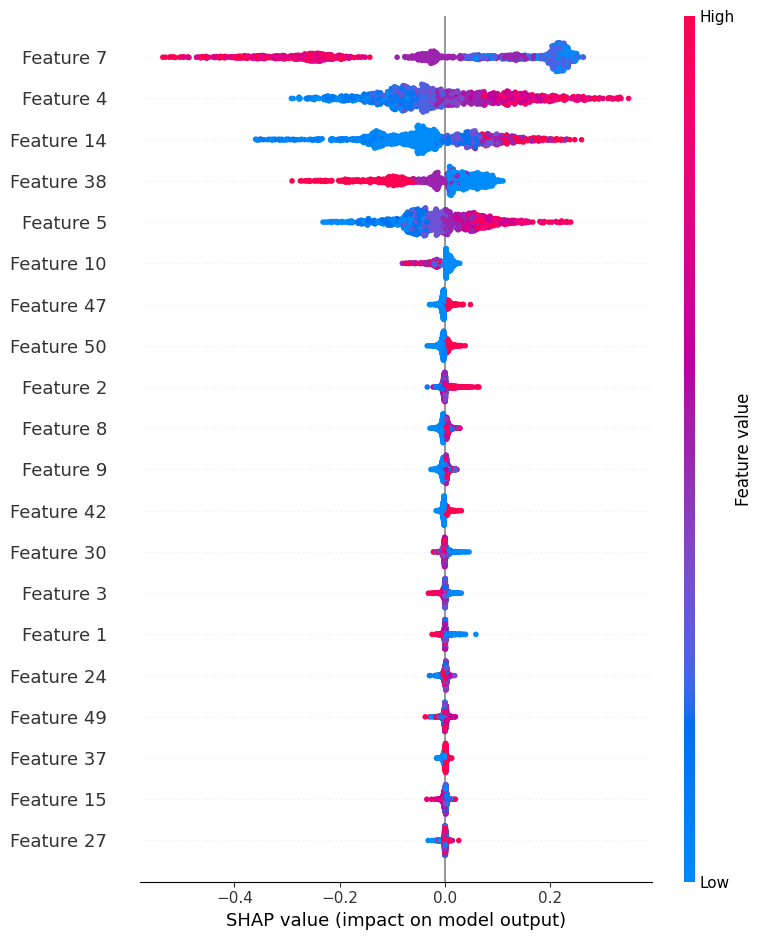

In [112]:
import shap
import numpy as np

# Wrap model predict_proba so it becomes callable
def model_predict(X):
    return model.predict_proba(X)[:, 1]  # For binary classification

explainer = shap.Explainer(model_predict, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)



In [114]:
feature_names = X_train.columns.tolist()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [113]:
import shap
import numpy as np
import pandas as pd

# Ensure X_test is a DataFrame with feature names
# If X_test is numpy array, convert it:
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=feature_names)  # Use your actual feature names

def model_predict(X):
    return model.predict_proba(X)[:, 1]

explainer = shap.Explainer(model_predict, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)  # Will now show actual feature names

NameError: name 'feature_names' is not defined

# **📊 Step 2: SHAP Summary Plot (Global Explanation)**

# 💡 Interpreting SHAP Summary Plot

* **Top features** - Most important for predictions
* **Red dots on right** - High feature value increases churn probability
* **Blue dots on left** - Low feature value decreases churn probability
* **Wide spread** - Feature has varying impact

In [ ]:
print("\n" + "="*80)
print("STEP 2: SHAP SUMMARY PLOT")
print("="*80)

# Summary plot (shows feature importance and impact)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title('SHAP Summary Plot - Feature Impact on Model Output',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ SHAP summary plot saved")

print("""
💡 How to Read SHAP Summary Plot:
   • Y-axis: Features (sorted by importance)
   • X-axis: SHAP value (impact on prediction)
   • Color: Feature value (red = high, blue = low)
   • Positive SHAP value → Increases prediction (more likely to churn)
   • Negative SHAP value → Decreases prediction (less likely to churn)
""")

# **📊 Step 3: SHAP Feature Importance**

In [ ]:
print("\n" + "="*80)
print("STEP 3: SHAP FEATURE IMPORTANCE")
print("="*80)

# Calculate mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values).mean(axis=0)

# Create dataframe
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['SHAP_Importance'],
         color='steelblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Mean |SHAP Value|', fontsize=12)
plt.title('Top 15 Features by SHAP Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_features['SHAP_Importance'].values):
    plt.text(v, i, f' {v:.4f}', va='center')

plt.tight_layout()
plt.savefig('shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ SHAP feature importance saved")

# **📊 Step 4: SHAP Dependence Plots**

In [ ]:
print("\n" + "="*80)
print("STEP 4: SHAP DEPENDENCE PLOTS")
print("="*80)

# Plot dependence for top 4 features
top_4_features = feature_importance_df.head(4)['Feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_4_features):
    feature_idx = list(X_test.columns).index(feature)

    shap.dependence_plot(
        feature_idx,
        shap_values,
        X_test,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Dependence: {feature}', fontweight='bold')

plt.tight_layout()
plt.savefig('shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ SHAP dependence plots saved")

print("""
💡 SHAP Dependence Plot:
   • X-axis: Feature value
   • Y-axis: SHAP value (impact on prediction)
   • Color: Interaction with another feature
   • Shows how feature value affects prediction
""")

# **🎯 Step 5: SHAP Waterfall Plot (Individual Prediction)**

In [ ]:
print("\n" + "="*80)
print("STEP 5: SHAP WATERFALL PLOT (Individual Explanation)")
print("="*80)

# Explain a single prediction
sample_idx = 0

print(f"Explaining prediction for sample {sample_idx}:")
print(f"Actual: {'Churn' if y_test.iloc[sample_idx] == 1 else 'No Churn'}")
print(f"Predicted: {'Churn' if y_pred[sample_idx] == 1 else 'No Churn'}")
print(f"Probability: {y_pred_proba[sample_idx]:.4f}")

# Create waterfall plot
shap_values_sample = shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[sample_idx].values,
    feature_names=X_test.columns.tolist()
)

plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap_values_sample, show=False)
plt.title(f'SHAP Waterfall Plot - Sample {sample_idx}',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ SHAP waterfall plot saved")

print("""
💡 SHAP Waterfall Plot:
   • Shows how each feature pushes prediction up or down
   • Starts from base value (average prediction)
   • Each bar shows feature contribution
   • Red bars push toward positive class (Churn)
   • Blue bars push toward negative class (No Churn)
""")

# **📊 Step 6: SHAP Force Plot**

In [ ]:
print("\n" + "="*80)
print("STEP 6: SHAP FORCE PLOT")
print("="*80)

# Initialize JavaScript for interactive plots
shap.initjs()

# Create force plot
sample_idx = 0
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_test.iloc[sample_idx],
    matplotlib=True,
    show=False
)

plt.savefig('shap_force_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ SHAP force plot saved")

print("""
💡 SHAP Force Plot:
   • Red: Features pushing prediction higher (toward Churn)
   • Blue: Features pushing prediction lower (toward No Churn)
   • Width of bars: Magnitude of impact
   • Base value: Average model output
   • Output value: Final prediction for this sample
""")

# **3. LIME Explanations**

# 💡 What is LIME?

* **Local Interpretable Model-agnostic Explanations**
* **Local explanations** - Explains individual predictions
* **Model-agnostic** - Works with any model
* **Approximation** - Fits simple model locally around the prediction

# **🎯 Step 1: Setup LIME**

In [ ]:
print("\n" + "="*80)
print("LIME EXPLANATIONS")
print("="*80)

# Install LIME if needed
# !pip install lime

import lime
import lime.lime_tabular

print("LIME library loaded successfully!")

# Create LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    mode='classification',
    random_state=42
)

print("✅ LIME explainer created!")

# **🔍 Step 2: Explain Individual Prediction with LIME**

In [ ]:
print("\n" + "="*80)
print("STEP 2: LIME EXPLANATION FOR INDIVIDUAL PREDICTION")
print("="*80)

# Choose a sample to explain
sample_idx = 0

print(f"Explaining sample {sample_idx}:")
print(f"Actual: {'Churn' if y_test.iloc[sample_idx] == 1 else 'No Churn'}")
print(f"Predicted: {'Churn' if y_pred[sample_idx] == 1 else 'No Churn'}")
print(f"Probability: {y_pred_proba[sample_idx]:.4f}")

# Generate explanation
explanation = lime_explainer.explain_instance(
    data_row=X_test.iloc[sample_idx].values,
    predict_fn=model.predict_proba,
    num_features=10
)

# Display as list
print("\nTop 10 Feature Contributions:")
for feature, weight in explanation.as_list():
    print(f"  {feature}: {weight:+.4f}")

# Save as figure
fig = explanation.as_pyplot_figure()
fig.set_size_inches(10, 6)
plt.title(f'LIME Explanation - Sample {sample_idx}',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('lime_explanation.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ LIME explanation saved")

print("""
💡 LIME Explanation:
   • Green bars: Features supporting the predicted class
   • Red/Orange bars: Features opposing the predicted class
   • Numbers show the weight/contribution of each feature
   • Features are shown with their actual values
""")

# **📊 Step 3: Compare LIME Explanations for Multiple Samples**

In [ ]:
print("\n" + "="*80)
print("STEP 3: COMPARE LIME EXPLANATIONS")
print("="*80)

# Explain 3 different samples
samples_to_explain = [0, 10, 20]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, sample_idx in enumerate(samples_to_explain):
    explanation = lime_explainer.explain_instance(
        data_row=X_test.iloc[sample_idx].values,
        predict_fn=model.predict_proba,
        num_features=5
    )

    # Get data for plotting
    exp_list = explanation.as_list()
    features = [f[0] for f in exp_list]
    weights = [f[1] for f in exp_list]
    colors = ['green' if w > 0 else 'red' for w in weights]

    # Plot
    axes[idx].barh(range(len(features)), weights, color=colors, alpha=0.7)
    axes[idx].set_yticks(range(len(features)))
    axes[idx].set_yticklabels(features, fontsize=8)
    axes[idx].set_xlabel('Contribution', fontsize=10)
    axes[idx].set_title(f'Sample {sample_idx}\nProb: {y_pred_proba[sample_idx]:.2f}',
                       fontweight='bold')
    axes[idx].axvline(x=0, color='black', linestyle='--', linewidth=1)
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('lime_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ LIME comparison saved")

# **🔄 Step 4: SHAP vs LIME Comparison**

In [ ]:
print("\n" + "="*80)
print("STEP 4: SHAP VS LIME COMPARISON")
print("="*80)

comparison_text = """
╔═══════════════════════════════════════════════════════════════════════════╗
║                          SHAP vs LIME COMPARISON                          ║
╠═══════════════════════════════════════════════════════════════════════════╣
║                                                                           ║
║  Aspect          │  SHAP                    │  LIME                      ║
║  ────────────────┼──────────────────────────┼────────────────────────── ║
║  Theory          │  Game Theory (Shapley)   │  Local Linear Approx      ║
║  Consistency     │  ✅ Yes                  │  ⚠️ Not guaranteed        ║
║  Speed (Trees)   │  ✅ Fast                 │  ⚠️ Moderate              ║
║  Speed (Others)  │  ⚠️ Slow                 │  ✅ Fast                  ║
║  Global Insights │  ✅ Yes                  │  ❌ No                    ║
║  Local Insights  │  ✅ Yes                  │  ✅ Yes                   ║
║  Accuracy        │  ✅ Higher               │  ⚠️ Good locally          ║
║  Interactions    │  ✅ Yes                  │  ⚠️ Limited               ║
║                                                                           ║
╠═══════════════════════════════════════════════════════════════════════════╣
║  WHEN TO USE SHAP:                                                        ║
║    • Need global + local insights                                        ║
║    • Want theoretical guarantees                                         ║
║    • Using tree-based models (very fast)                                 ║
║    • Need to understand feature interactions                             ║
║                                                                           ║
║  WHEN TO USE LIME:                                                        ║
║    • Quick local explanations only                                       ║
║    • Model is very complex (non-tree)                                    ║
║    • Don't need consistency across explanations                          ║
║    • Want simple, intuitive explanations                                 ║
╚═══════════════════════════════════════════════════════════════════════════╝
"""

print(comparison_text)

with open('SHAP_vs_LIME_Comparison.txt', 'w') as f:
    f.write(comparison_text)

print("✅ Comparison saved")